# Bank Marketing: Predict Who Will Subscribe a Term Deposit

### Author: Bo Chen

# Introduction



## Problem and Goal

The task is to predict if the client will subscribe a term deposit after direct marketing campaigns (phone calls) of a Portuguese banking institution. 

The dataset is acquired from [UCI](http://archive.ics.uci.edu/ml/datasets/Bank+Marketing#) and is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.


# Data Exploration

In [362]:
# load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [326]:
#import data
bank = pd.read_csv("bank-full.csv", sep=";")
bank

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [327]:
# look at main characters of the data and see if there is any missing values
bank.info()
bank.isnull().any()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
y            False
dtype: bool

In [328]:
# Assessing if duplicated records are found in the dataset
bank.duplicated().sum()

0

# Explanatory Data Analysis (EDA)

## Describing the features

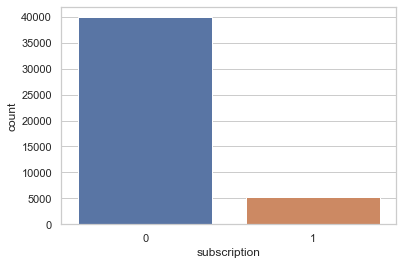

In [329]:
# change the name of y
bank.rename(index=str, columns={'y': 'subscription'}, inplace=True)
bank['subscription'] = bank['subscription'].apply(
    lambda x: 0 if x == 'no' else 1)
# replace number of days that passed by after the client was last contacted from a previous campaign
# 0 means the client has not been contacted
bank['pdays'] = bank['pdays'].apply(lambda x: 0 if x == -1 else x)
# Check the target variable
sns.set(style="whitegrid")
sns.countplot(bank['subscription'])

This a scaring imbalanced dataset, so we need to deal with this problem in the later stage.

In [330]:
# Extract descriptive statistics
bank.describe()

,age,balance,day,duration,campaign,pdays,previous,subscription
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,41.015195,0.580323,0.116985
std,10.618762,3044.765829,8.322476,257.527812,3.098021,99.792615,2.303441,0.321406
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,0.000000,0.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,0.000000,0.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,0.000000,0.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,1.000000


In [331]:
bank.describe(include='O')

,job,marital,education,default,housing,loan,contact,month,poutcome
count,45211,45211,45211,45211,45211,45211,45211,45211,45211
unique,12,3,4,2,2,2,3,12,4
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown
freq,9732,27214,23202,44396,25130,37967,29285,13766,36959


We can appreciate that our features do not seem to be skewed as the mean and the median are roughly similar. This suggests that we would not need to transform our data, at least based on their distribution. Additionally, the range of each category is quite legitimate. However we notice that there are huge gaps between 75% and max, min and 25% value in the balance column, it is reasonable to doubt that outliers exist in the dataset.

### Identify Outliers using IQR rule

In [332]:
def identify_outlier(df, col):
    stat = df[col].describe()
    print(stat)
    IQR = stat['75%']-stat['25%']
    upper = stat['75%']+1.5*IQR
    lower = stat['25%']-1.5*IQR
    print('The upper and lower bounds for the potential outliers are {} and {}'.format(
        upper, lower))

In [333]:
# identify outliers for the age columns
identify_outlier(bank, "balance")

count     45211.000000
mean       1362.272058
std        3044.765829
min       -8019.000000
25%          72.000000
50%         448.000000
75%        1428.000000
max      102127.000000
Name: balance, dtype: float64
The upper and lower bounds for the potential outliers are 3462.0 and -1962.0


In [334]:
bank1 = bank[(bank['balance'] < 3462) & (bank['balance'] > -1962)]
bank1

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscription
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,0,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,0,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,0,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,0,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,0,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45205,25,technician,single,secondary,no,505,no,yes,cellular,17,nov,386,2,0,0,unknown,1
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,0,0,unknown,1
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,0,0,unknown,1
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,0,0,unknown,0


## Descriptive Figures

### Distribution plots 

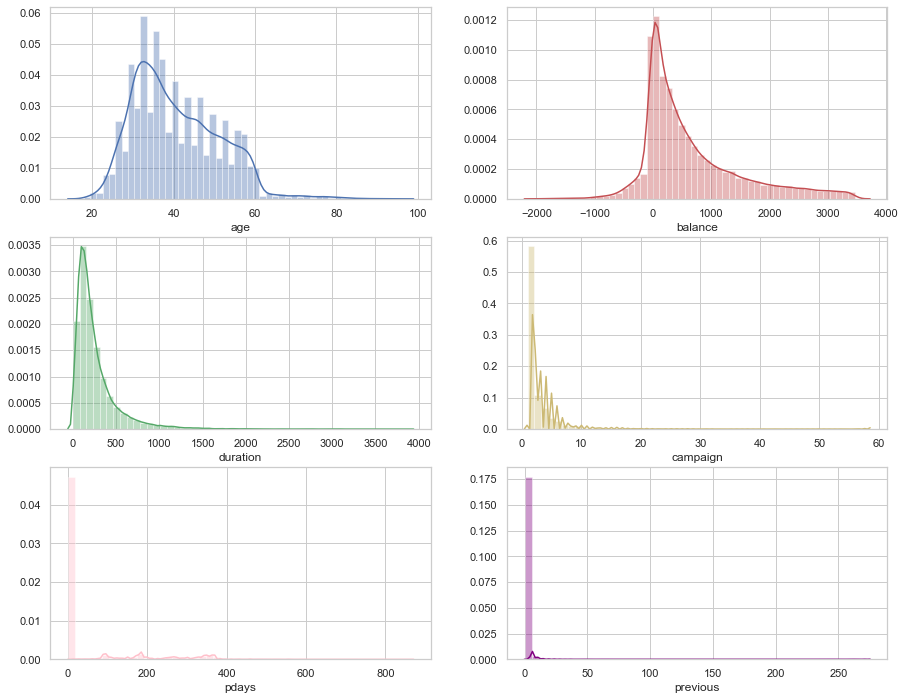

In [335]:
plt.figure(figsize=(15, 12))
plt.subplot(3, 2, 1)
sns.distplot(bank1['age'])
plt.subplot(3, 2, 2)
sns.distplot(bank1['balance'], color='r')
plt.subplot(3, 2, 3)
sns.distplot(bank1['duration'], color='g')
plt.subplot(3, 2, 4)
sns.distplot(bank1['campaign'], color='y')
plt.subplot(3, 2, 5)
sns.distplot(bank1['pdays'], color='pink', kde_kws={'bw': 0.1})
plt.subplot(3, 2, 6)
sns.distplot(bank1['previous'], color='purple', kde_kws={'bw': 0.1})

From the above distributions, we can observe that:
- The distribution of customer age is quite extensive, from 18 to 95. However, most of them are in the mid-age(30s-40s).
- The balance distribution is also wide spread, suggesting a large variability in customer balances.
- The duration of contact has a median about 300 seconds and most of them are very short, but there are still a number of large outliers which worth being investigated.
- Half of the clients were contacted by the bank for the second time and most of them are contacted by one to three times. However, some clients are contacted by 58 times at most, which is abnormal. It may be because these clients have special needs from the bank.
- Most clients are contacted recently or never been contacted and only a few has been contacted a few years ago.
- Most clients hasn't been contacted before this compaign and only a few get contacted many times.
- Furthermore, the age is little bit skewed which could potentially bias our model later on. In a subsequent step, we will apply log transformation at least on the age feature.

### Scatter Matrix and Correlation Matrix

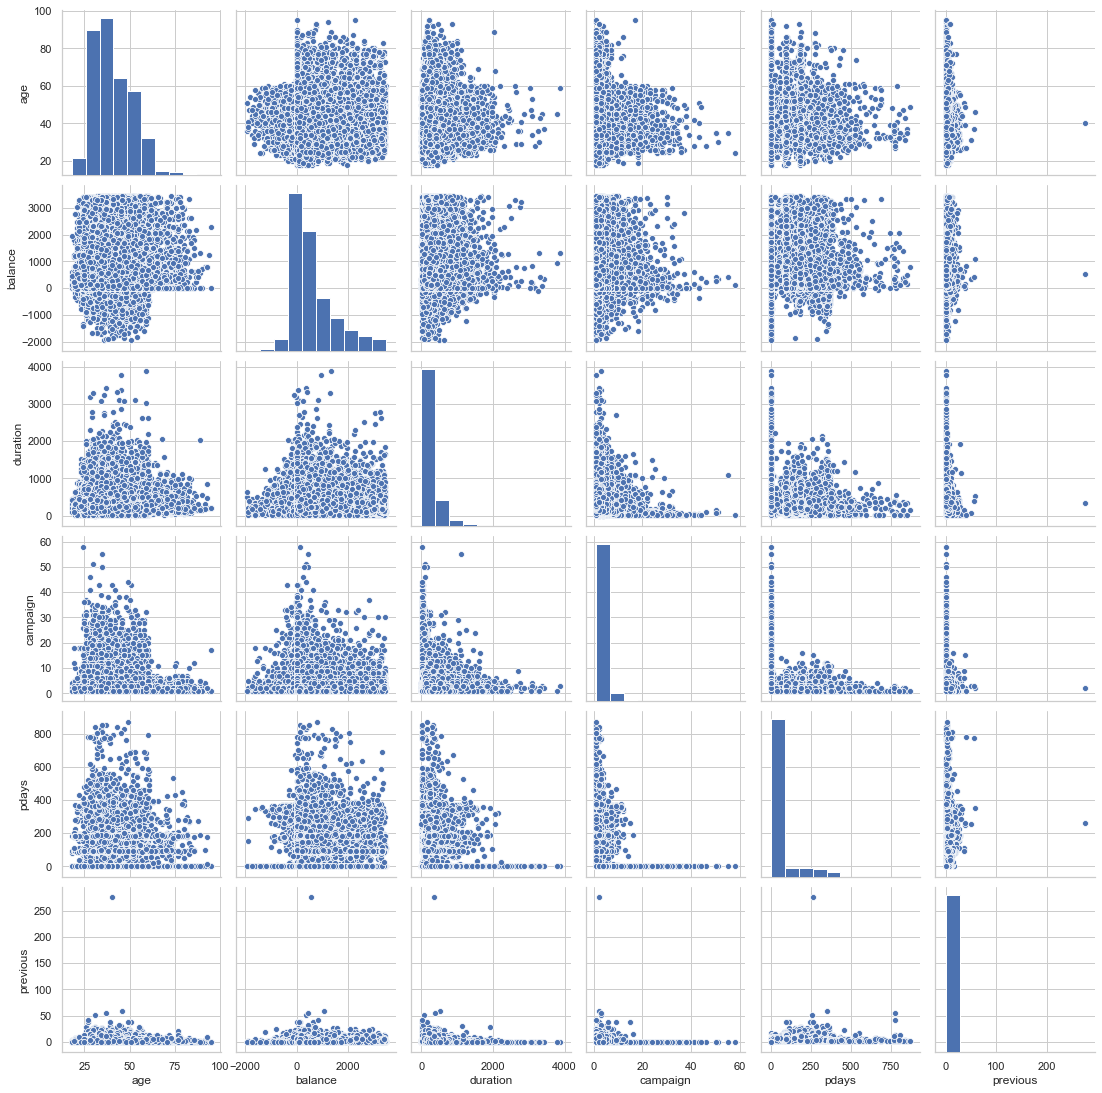

In [336]:
sns.pairplot(
    bank1[['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']])

Based on the above scatter matrix, we cannot find any valuable relationship among age, balance, duration, campaign, previous and pdays.

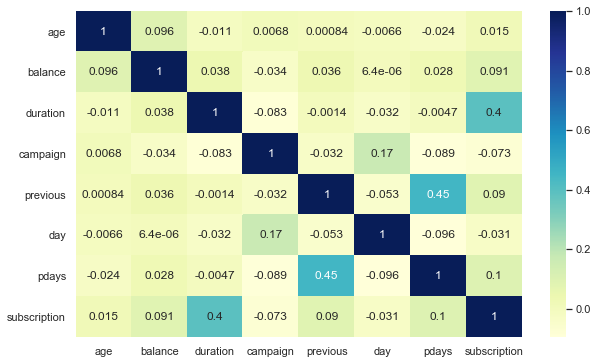

In [337]:
corr = bank1[['age', 'balance', 'duration', 'campaign',
              'previous', 'day', 'pdays', 'subscription']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, cmap="YlGnBu", annot=True)

The cross-correlation revealed relatively strong relationship between our target feature and the last contact duration. There is also a mild correlation between subscription and pdays, balance or previous. The correlation is similar which is close to 0.1. Now, we would need to keep these relationship in mind since there seems to be some collinearity between the explanatory features as well(e.g. previous vs pdays, day vs campaign).

### Plots Regarding Target Feature

In [338]:
# Subsetting by subscriptions
sub_yes = bank1["subscription"] == 1
sub_no = bank1["subscription"] == 0

# Creating the plots
features = ["age", "balance", "duration",
            "pdays", "previous", "campaign", "day"]
labels = ["Subscription", "No Subscription"]

# create distribution plots for each numerical feature vs target variable


def create_distplots(features, labels):
    plt.figure(figsize=(15, 15))
    for ft in features:
        plt.subplot(4, 2, features.index(ft)+1)
        sns.distplot(bank1[ft][sub_yes], label=labels[0],
                     color="b", kde_kws={'bw': 0.1})
        sns.distplot(bank1[ft][sub_no], label=labels[1],
                     color="r", kde_kws={'bw': 0.1})
        plt.axvline(bank1[ft][sub_yes].mean(), linestyle='--', color="b")
        plt.axvline(bank1[ft][sub_no].mean(), linestyle='--', color="r")
        plt.legend()

# create violin plots for each numerical feature vs target variable


def create_violinplots(features):
    plt.figure(figsize=(15, 15))
    for ft in features:
        plt.subplot(4, 2, features.index(ft)+1)
        sns.violinplot(x=bank1['subscription'], y=bank1[ft])

### Violin plots with respect to target feature

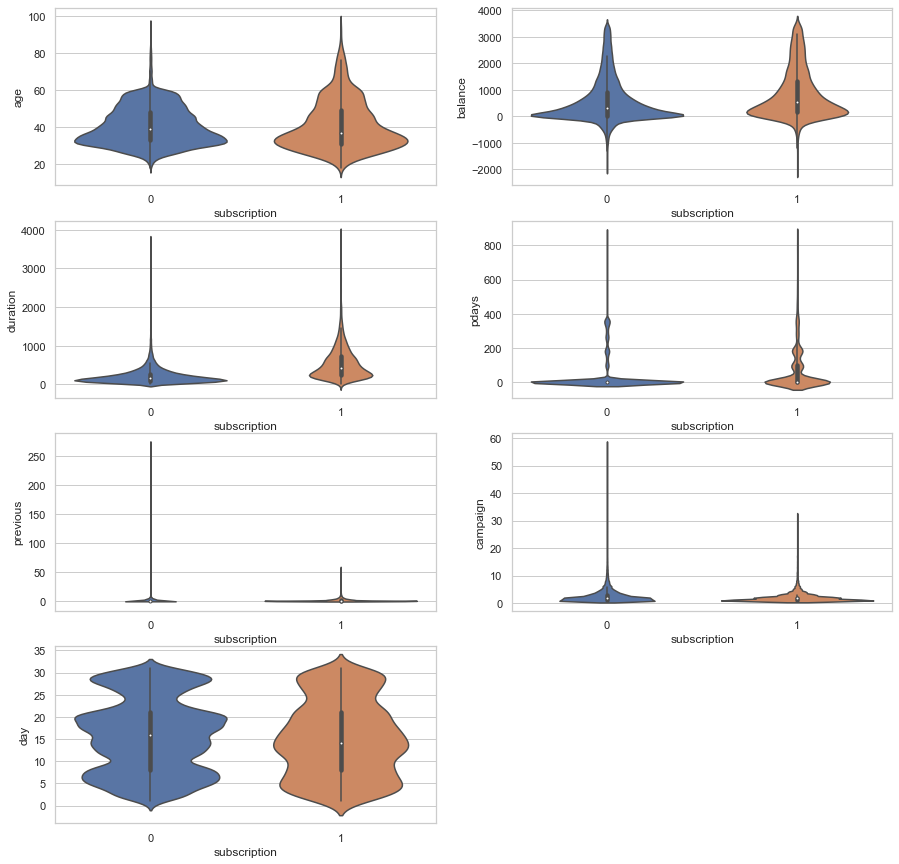

In [339]:
create_violinplots(features)

### Distribution plots  with respect to target feature

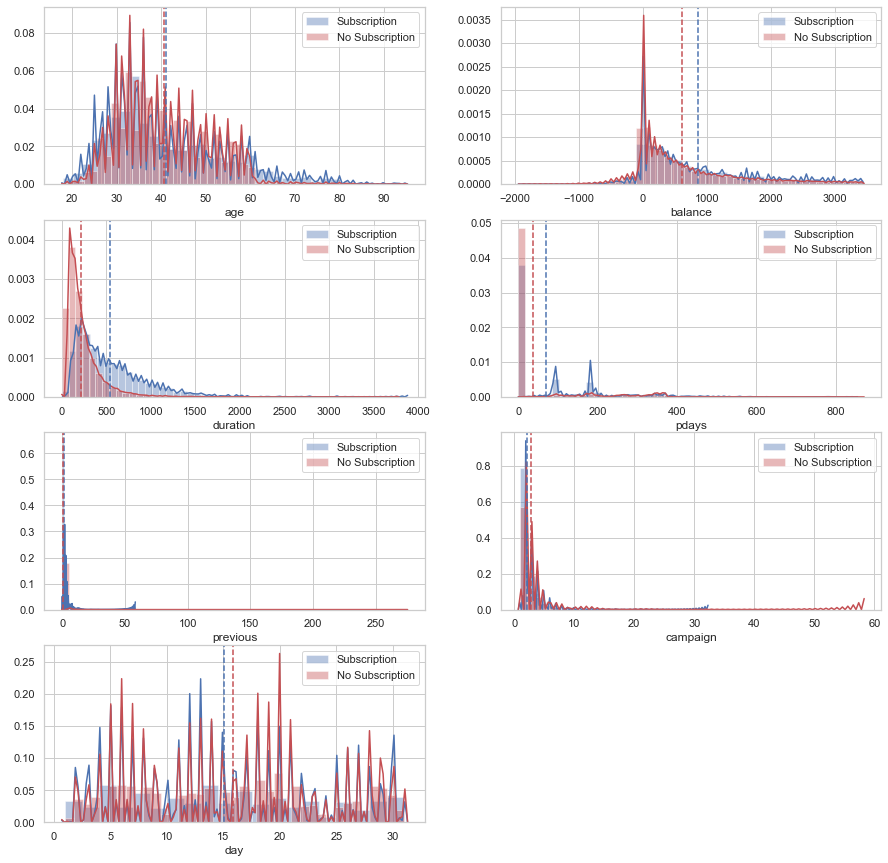

In [340]:
create_distplots(features, labels)

**Insights**
- Older and younger people are more likely to subscribe the term deposit. It makes sense since term deposit is the least risky investment which is suitable for these two groups of people.
- Clients with average or high balance are more likely to subscribe. In the future, the bank should focus more on these group of people.
- Longer contact duration is more likely to lead to a campaign success.
- People who have a contact period of about 150 days from contact by previous campaign are more likely to subscribe.
- There is no significant difference of subscription on last contact day of the month and number of contacts performed during and before this campaign.

### Barplots of categorical variables with repect to target variable

In [341]:
# get the probability of subscription based on the category and draw the barplot
def percent_sub(col):
    percent = bank1.groupby(
        [col])['subscription'].value_counts(normalize=True).rename(
            'percentage').mul(100).reset_index().sort_values('subscription')
    percent = percent[percent['subscription'] == 1]
    sns.barplot(x='percentage',
                y=col,
                data=percent,
                order=percent.sort_values('percentage', ascending=False)[col])

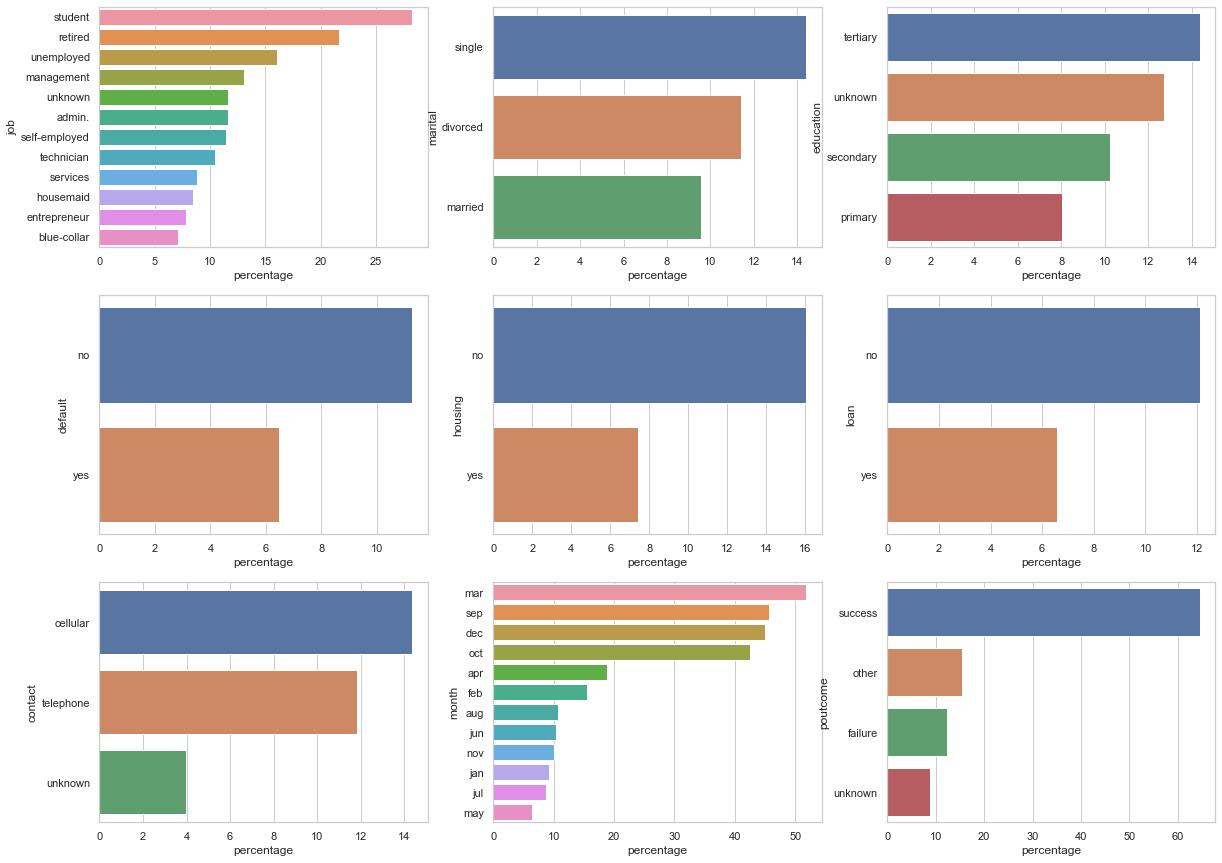

In [342]:
# plot each categorical feature
plt.figure(figsize=(20, 15))
cat_list = bank1.select_dtypes(exclude=['int64']).columns.tolist()
for ft in cat_list:
    plt.subplot(3, 3, cat_list.index(ft)+1)
    percent_sub(ft)

**Insights**
- Students and retirees are the major customers for the deposit description, which aligns with the previous finding about age.
- People with higher education tends to be more likely to subscribe.
- People who don't have credit in default or who don't have housing or personal loan should be targeted customers.
- The success of marketing campaign is largely affected by the effect of previous campaign.
- The marketing campaign is recommended to initiate during fall or spring as these two seasons seem to yield a better result.
- The contact method doesn't affect too much about client's choice of subscription.

# Feature Engineering

### Removing Unnecessary Features

As we observe from EDA part, the variables contact, day, campaign and previous do not affect the target variable too much, so they are removed for modeling.

In [343]:
bank1.drop(columns=['contact', 'day', 'campaign', 'previous'], inplace=True)

### Skewed Features: Log Transform

Before machine learning, we are going to transform skewed variables to avoid future biases in the model. To potentially solve this issue, we will apply a logarithmic transformation to reduce the effect of outliers and reduce the distribution's range.

From EDA, we know that age should be adjusted to an unbiased level.

In [344]:
bank1['log_age'] = np.log(bank1['age'])

### Standarization of Numerical Variables

In [345]:
num_list = bank1.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_list.remove('subscription')
df = bank1.copy()
df[num_list] = StandardScaler().fit_transform(df[num_list])
df.head()

,age,job,marital,education,default,balance,housing,loan,month,duration,pdays,poutcome,subscription,log_age
0,1.659861,management,married,tertiary,no,1.779768,yes,no,may,0.018934,-0.407896,unknown,0,1.535409
1,0.322248,technician,single,secondary,no,-0.724340,yes,no,may,-0.411584,-0.407896,unknown,0,0.442592
2,-0.728734,entrepreneur,married,secondary,no,-0.756322,yes,yes,may,-0.705119,-0.407896,unknown,0,-0.695435
3,0.608879,blue-collar,married,unknown,no,1.025219,yes,no,may,-0.642498,-0.407896,unknown,0,0.703512
4,-0.728734,unknown,single,unknown,no,-0.757507,no,no,may,-0.227635,-0.407896,unknown,0,-0.695435


### drop unknown and other values

In [348]:
df1 = df[(df['job'] != 'unknown') & (df['education'] != 'unknown') &
         (df['poutcome'] != 'unknown') & (df['poutcome'] != 'other')]
df1.head()

,age,job,marital,education,default,balance,housing,loan,month,duration,pdays,poutcome,subscription,log_age
24060,-0.728734,admin.,married,tertiary,no,0.286069,no,no,oct,-0.849929,1.090129,failure,0,-0.695435
24064,-0.728734,services,married,secondary,no,3.320848,yes,no,oct,-0.438980,0.494887,failure,1,-0.695435
24077,-0.442102,management,married,tertiary,no,-0.758691,yes,no,oct,-0.454635,1.010763,failure,1,-0.351231
24080,1.468773,technician,married,secondary,no,-0.061000,yes,no,oct,1.024781,1.050446,success,1,1.396593
24127,0.991054,admin.,single,secondary,no,2.951273,no,no,nov,0.754729,1.338146,failure,0,1.026618


### Processing Categorical Feature: Label Encoding

In [349]:
def bool_trans(data, col):
    data[col] = data[col].apply(lambda x: 1 if x == 'yes' else 0)


bool_trans(df1, 'default')
bool_trans(df1, 'housing')
bool_trans(df1, 'loan')
df1.head()

,age,job,marital,education,default,balance,housing,loan,month,duration,pdays,poutcome,subscription,log_age
24060,-0.728734,admin.,married,tertiary,0,0.286069,0,0,oct,-0.849929,1.090129,failure,0,-0.695435
24064,-0.728734,services,married,secondary,0,3.320848,1,0,oct,-0.438980,0.494887,failure,1,-0.695435
24077,-0.442102,management,married,tertiary,0,-0.758691,1,0,oct,-0.454635,1.010763,failure,1,-0.351231
24080,1.468773,technician,married,secondary,0,-0.061000,1,0,oct,1.024781,1.050446,success,1,1.396593
24127,0.991054,admin.,single,secondary,0,2.951273,0,0,nov,0.754729,1.338146,failure,0,1.026618


### Processing Categorical Feature: One Hot-Encoding

In [350]:
df_final = pd.get_dummies(df1)
# drop untransferred age column
df_final.drop(columns=['age'], inplace=True)
df_final.head()

,default,balance,housing,loan,duration,pdays,subscription,log_age,job_admin.,job_blue-collar,...,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_success
24060,0,0.286069,0,0,-0.849929,1.090129,0,-0.695435,1,0,...,0,0,0,0,0,0,1,0,1,0
24064,0,3.320848,1,0,-0.438980,0.494887,1,-0.695435,0,0,...,0,0,0,0,0,0,1,0,1,0
24077,0,-0.758691,1,0,-0.454635,1.010763,1,-0.351231,0,0,...,0,0,0,0,0,0,1,0,1,0
24080,0,-0.061000,1,0,1.024781,1.050446,1,1.396593,0,0,...,0,0,0,0,0,0,1,0,0,1
24127,0,2.951273,0,0,0.754729,1.338146,0,1.026618,1,0,...,0,0,0,0,0,1,0,0,1,0


# Modeling

In this section, we will test various algorithms with our problem at hand to choose the best one in order to tune the model to its best parameters. In order to assess the different algorithms, we will use the metric **Precision** in this business case. Since we don't waste the money on the kind of people who will not subscribe the term deposit but the model tells us they will do so. We want to limit **False Positive** and **False Negative** does not cost so much since people who will subscribe the deposit but can't be captured by the model will bring profit anyway. Therefore, we need to develop an interpretable model that has a great **precision** to minimize the **false positive** which incur loss of money.

We are going to consider the following three classification models:
- logistic regression: the basic classification model and sometimes can do really well.
- random forest classification: fairly use all of our features and essentially reduce the overfitting problem.
- XGBoost: Focuses on learning the remaining errors (aka error fitting). In general, XGBoost is a lot faster than Sklearn's Gradient Boosting and has some built in regularization.

## Data Preparation

In [351]:
# separate explanatory and target variables
y = df_final['subscription']
X = df_final.drop(columns=['subscription'])

In [352]:
# Creating tran and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

## Data Resampling (Upsample using SMOTE)

As we mentioned earlier, we have an imbalanced dataset. So we decide to use SMOTE to use the nearest neighbors of the minority observations to create new synthetic and balanced data.

In [353]:
sm = SMOTE(random_state=42, sampling_strategy=1.0)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)

## Hyperparameter Tuning

In this part, we are going to do hyperparameter tuning for each model to find the maximum potential performance.

### Logistic Regression

In [372]:
results = []
# Enumerate through different C values and store results
for C in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    clf = LogisticRegression(C=C)
    clf.fit(X_train_sm, y_train_sm)
    results.append(
        {
            'C': C,
            'train_precision': precision_score(y_train_sm, clf.predict(X_train_sm)),
            'test_precision': precision_score(y_test, clf.predict(X_test))
        })

# Display Results
C_df = pd.DataFrame(results).set_index('C').sort_index()
C_df

,train_precision,test_precision
C,,
0.001,0.826387,0.583587
0.010,0.846695,0.620370
0.100,0.870968,0.651724
1.000,0.893237,0.680934
10.000,0.900382,0.687243
100.000,0.901404,0.687500
1000.000,0.901723,0.686192


In [375]:
parameters = {"C": [2, 3, 4, 5, 6, 7, 8, 9, 10], 'penalty': ['l1', 'l2']}

model = LogisticRegression()

# Grid Search on the classifier using 'precision' as the scoring method
grid_lr = GridSearchCV(model, param_grid=parameters,
                       scoring='precision').fit(X_train_sm, y_train_sm)

In [376]:
# get the best model
grid_lr.best_estimator_

LogisticRegression(C=9)

### Random Forest

In [354]:
results = []
# Enumerate through different max_depth values and store results
for max_depth in [2, 3, 4, 5, 10, 20, 50, 100]:
    clf = RandomForestClassifier(max_depth=max_depth)
    clf.fit(X_train_sm, y_train_sm)
    results.append(
        {
            'max_depth': max_depth,
            'train_precision': precision_score(y_train_sm, clf.predict(X_train_sm)),
            'test_precision': precision_score(y_test, clf.predict(X_test))
        })

# Display Results
max_depth_df = pd.DataFrame(results).set_index('max_depth').sort_index()
max_depth_df

,train_precision,test_precision
max_depth,,
2,0.848546,0.616438
3,0.841507,0.603960
4,0.847997,0.624161
5,0.850334,0.610224
10,0.906765,0.630573
20,0.993932,0.656250
50,1.000000,0.665468
100,1.000000,0.654804


It seems that max_depth in the range of (20,100) should be optimal.

In [355]:
results = []
# Enumerate through different n_estimator values and store results
n_estimator_options = [10, 20, 50, 100, 200, 300, 500]
for n_estimators in n_estimator_options:
    clf = RandomForestClassifier(n_estimators=n_estimators)
    clf.fit(X_train_sm, y_train_sm)
    results.append(
        {
            'n_estimators': n_estimators,
            'train_precision': precision_score(y_train_sm, clf.predict(X_train_sm)),
            'test_precision': precision_score(y_test, clf.predict(X_test))
        })

n_estimators_df = pd.DataFrame(results).set_index('n_estimators').sort_index()
n_estimators_df

,train_precision,test_precision
n_estimators,,
10,0.995716,0.661479
20,0.998473,0.660517
50,0.999695,0.654930
100,1.000000,0.660650
200,1.000000,0.655052
300,1.000000,0.644366
500,1.000000,0.654930


n-estimator should be ideal around 100.

In [357]:
# grid search with hypothetical parameters
param_grid = {'n_estimators': [80, 90, 100, 120, 150],
              'max_depth': [30, 40, 50, 60, 70]
              }
rfor = GridSearchCV(RandomForestClassifier(), param_grid=param_grid,
                    verbose=10, cv=5, n_jobs=-1, scoring='precision')
rfor.fit(X_train_sm, y_train_sm)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   60.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 123 out of 125 | elapsed:  2.6min remaining:    2.5s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  2.7min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [30, 40, 50, 60, 70],
                         'n_estimators': [80, 90, 100, 120, 150]},
             scoring='precision', verbose=10)

In [358]:
# get the model with best performance
rfor.best_estimator_

RandomForestClassifier(max_depth=70, n_estimators=80)

### XGBoost

In [359]:
# Enumerate through different max_depth values and store results
results = []
for max_depth in [2, 3, 4, 5, 10, 12, 15]:
    clf = XGBClassifier(max_depth=max_depth)
    clf.fit(X_train_sm, y_train_sm)
    results.append(
        {
            'max_depth': max_depth,
            'train_precision': precision_score(y_train_sm, clf.predict(X_train_sm)),
            'test_precision': precision_score(y_test, clf.predict(X_test))
        })

# Display Results
max_depth_df = pd.DataFrame(results).set_index('max_depth').sort_index()
max_depth_df

,train_precision,test_precision
max_depth,,
2,0.886792,0.648026
3,0.915677,0.658703
4,0.945275,0.649306
5,0.978426,0.669039
10,1.000000,0.669118
12,1.000000,0.656827
15,1.000000,0.650909


max depth should be around 10.

In [360]:
results = []
n_estimator_options = [50, 60, 100, 150, 200, 500, 750, 1000]
for n_estimators in n_estimator_options:
    clf = XGBClassifier(n_estimators=n_estimators)
    clf.fit(X_train_sm, y_train_sm)
    results.append(
        {
            'n_estimators': n_estimators,
            'train_precision': precision_score(y_train_sm, clf.predict(X_train_sm)),
            'test_precision': precision_score(y_test, clf.predict(X_test))
        })

n_estimators_df = pd.DataFrame(results).set_index('n_estimators').sort_index()
n_estimators_df

,train_precision,test_precision
n_estimators,,
50,0.964458,0.647458
60,0.975425,0.658537
100,0.994509,0.653430
150,0.998172,0.658088
200,0.999695,0.658273
500,1.000000,0.672794
750,1.000000,0.669118
1000,1.000000,0.686792


n estimators should be optimal at 1000. However, for more time efficiency,we see value around 500 is a also good choice but takes less operating time.

In [364]:
results = []
for learning_rate in [0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1]:
    clf = XGBClassifier(
        max_depth=2, learning_rate=learning_rate, n_estimators=200)
    clf.fit(X_train_sm, y_train_sm)
    results.append(
        {
            'learning_rate': learning_rate,
            'train_precision': precision_score(y_train_sm, clf.predict(X_train_sm)),
            'test_precision': precision_score(y_test, clf.predict(X_test))
        })

learning_rate_lr = pd.DataFrame(results).set_index(
    'learning_rate').sort_index()
learning_rate_lr

,train_precision,test_precision
learning_rate,,
0.05,0.858671,0.620178
0.10,0.876765,0.638095
0.20,0.893926,0.650000
0.40,0.916842,0.678322
0.60,0.936513,0.681818
0.80,0.949588,0.661765
1.00,0.956482,0.666667


Theoretically, optimal values of learning rate should be between 0.01-0.2). ESL states that the best strategy might be to set learning_rate low (<0.1) and then choose n_estimators by early stopping.In this case, we still take value 0.6 and 0.7 into account they really perform well.

In [377]:
# grid search with potential parameters
param_grid_grad = {'n_estimators': [300, 400, 450, 500, 600],
                   "max_depth": [9, 10, 11],
                   "learning_rate": [0.02, 0.05, 0.1, 0.2, 0.6, 0.7]
                   }
gs_cv = GridSearchCV(XGBClassifier(), param_grid=param_grid_grad,
                     cv=5, n_jobs=-1, scoring='precision').fit(X_train_sm, y_train_sm)

In [378]:
# return the best model
gs_cv.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=11,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## Model Seletion

In this section, three models will be compared with their performance based on the precision metrics.

In [368]:
# get the mean and standard deviation precision score for each model
def cv_model(model, feature_df, target_df, precision, cv_std):
    score = cross_val_score(model, feature_df, target_df,
                            cv=5, scoring='precision')
    precision[model] = np.mean(score)
    cv_std[model] = np.std(score)

# Fit each model and get precision score and confusion matrix in the test set


def pred_model(model, precision_metrics, conf_matrix):
    fit = model.fit(X_train_sm, y_train_sm)
    precision_metrics[model] = precision_score(y_test, fit.predict(X_test))
    conf_matrix[model] = confusion_matrix(y_test, fit.predict(X_test))

# print all the metrics


def print_result(model, precision, cv_std, precision_metrics, conf_matrix):
    print('\nModel:\n', model)
    print('Mean Precision during CV:\n', precision[model])
    print('Standard deviation during CV:\n', cv_std[model])
    print('Precision in the Test Set:\n', precision_metrics[model])
    print('Confusion Matrix:\n', conf_matrix[model])

In [380]:
# create models -- hyperparameter tuning already done by GridSearch
models = []
precision = {}
cv_std = {}
precision_metrics = {}
conf_matrix = {}
lr = LogisticRegression(C=9, random_state=42)
rf = RandomForestClassifier(random_state=42, max_depth=70, n_estimators=80)
xgb = XGBClassifier(max_depth=11, n_estimators=400,
                    random_state=42, learning_rate=0.1)
models.extend([lr, rf, xgb])

# parallel cross-validate models, using precision as evaluation metric, and print summaries
print("Beginning cross validation")
for model in models:
    cv_model(model, X_train_sm, y_train_sm, precision, cv_std)
    pred_model(model, precision_metrics, conf_matrix)
    print_result(model, precision, cv_std, precision_metrics, conf_matrix)

Beginning cross validation

Model:
 LogisticRegression(C=9, random_state=42)
Mean Precision during CV:
 0.8946262321247961
Standard deviation during CV:
 0.02053018823139156
Precision in the Test Set:
 0.6872427983539094
Confusion Matrix:
 [[744  76]
 [ 90 167]]

Model:
 RandomForestClassifier(max_depth=70, n_estimators=80, random_state=42)
Mean Precision during CV:
 0.8826487918444215
Standard deviation during CV:
 0.010937814547859404
Precision in the Test Set:
 0.6385964912280702
Confusion Matrix:
 [[717 103]
 [ 75 182]]

Model:
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=11,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_la

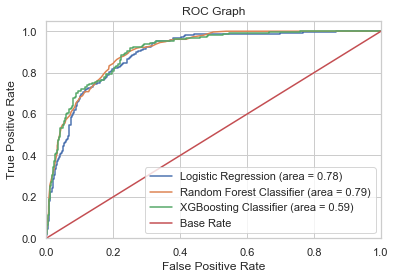

In [388]:
# Fit all three models
lr = lr.fit(X_train_sm, y_train_sm)
rf = rf.fit(X_train_sm, y_train_sm)
xgb = xgb.fit(X_train_sm, y_train_sm)

# Calculate roc_auc_score for each model prediction
lr_auc = roc_auc_score(y_test, lr.predict(X_test))
rf_auc = roc_auc_score(y_test, rf.predict(X_test))
xgb_auc = roc_auc_score(y_test, xgb.predict(X_test))

# Create ROC Graph
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:, 1])
rf_fpr, rf_tpr, rf_thresholds = roc_curve(
    y_test, rf.predict_proba(X_test)[:, 1])
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(
    y_test, xgb.predict_proba(X_test)[:, 1])


plt.figure()

# Plot Logistic Regression ROC
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % lr_auc)

# Plot Random Forest ROC
plt.plot(rf_fpr, rf_tpr, label='Random Forest Classifier (area = %0.2f)' % rf_auc)


# Plot XGBoosting ROC
plt.plot(xgb_fpr, xgb_tpr, label='XGBoosting Classifier (area = %0.2f)' % gbc_auc)


# Plot Base Rate ROC
plt.plot([0, 1], [0, 1], label='Base Rate')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

As we can see, logistic regression is the most successful model which effectively limit false positives.

## Feature Importances

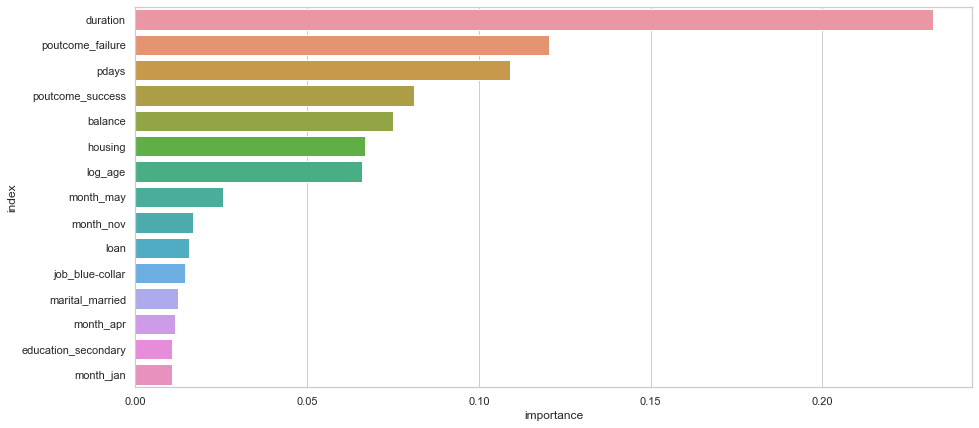

In [419]:
# Get feature importances
rf_importances = pd.DataFrame(rf.feature_importances_,
                              index=X_train.columns,
                              columns=['importance'
                                       ]).sort_values('importance',
                                                      ascending=False).reset_index()
plt.figure(figsize=(15, 7))
sns.barplot(x='importance', y='index', data=rf_importances[0:15])

# Final Recommendations

## Target Customer

- Age: Young and old people (typically age<30 and age>60)
- Balance: People with relatively high balance (typically balance>1000)
- loan: People who do not have housing or private loans.
- Outcome from last campaign: People who indicate a successful outcome of the previous marketing campaign.
- Old customers: People who was previously get contacted before. 

## Seasonal Marketing

Marketing timing is an very essential for businesses. As we observe from EDA and feature importance, marketing seasons make a difference in results. It appears that spring and autumn marketing campaigns are the most successful. The bank should consider initiating its telemarketing campaign in fall and spring.

## Strategy Marketing

Marketing strategy is also key factor of success. Here is a tip to improve possibility of campaign success:
Try best to make the campaign engaging,so the customer is willing to participate in a long duration. Longer contact duration potentially indicates a success.